In [89]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  1 16:03:19 2025

@author: azakeri20
"""
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        
        self.fc1 = nn.Linear(input_dims, 256)
        #self.fc_hidden = nn.Linear(256, 128)  # New intermediate layer
        self.fc2 = nn.Linear(256, n_actions)


        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        #x = F.relu(self.fc_hidden(x))  # Apply activation to new layer
        actions = self.fc2(x)
        return actions

    def save_checkpoint(self):
        #print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        #print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [90]:
import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        #print('Input SHAPE=', input_shape)
        #print(self.state_memory)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        #print('index',index)
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [91]:
import numpy as np
import torch as T
#from deep_q_network import DeepQNetwork
#from dqn_network import DeepQNetwork
#from replay_memory import ReplayBuffer

class DQNAgent(object):
    def __init__ (self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min = 0.01, eps_dec = 5e-7,
                 replace = 1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [0 , 1 , 2]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)   # input dimention is 1 * 7 is input shape

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,  # the current Q-net.
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions, # the target Q-net.
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)
    #%%                                
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmin(actions).item()   # Changing to argmin for COST
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min


    def save_models(self):
        print("... saving models ...")
        T.save({
            'q_eval_state_dict': self.q_eval.state_dict(),
            'q_next_state_dict': self.q_next.state_dict(),
            'optimizer_state_dict': self.q_eval.optimizer.state_dict(),  # assumes optimizer is inside q_eval
            'epsilon': self.epsilon,
            'learn_step_counter': self.learn_step_counter
            # optionally: save replay buffer if continuing training
        }, self.chkpt_dir + '/dqn_checkpoint.pth')

    def load_models(self):
        print("... loading models ...")
        checkpoint = T.load(self.chkpt_dir + '/dqn_checkpoint.pth')
        self.q_eval.load_state_dict(checkpoint['q_eval_state_dict'])
        self.q_next.load_state_dict(checkpoint['q_next_state_dict'])
        self.q_eval.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.learn_step_counter = checkpoint['learn_step_counter']


    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).min(dim=1)[0]  # max in original, Changing to min for the COST

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()
#print('ok')


In [92]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

class env_goal_crrl():

        def __init__(self,  q, rho, p, alpha_tr, rand_cost, action_mat  ):

            self.q = q; self.rho = rho; self.alpha_tr = alpha_tr; self.p = p

        def step(self, action, state, X_1, X_2):  # Creating Next STate and Reward accroding to the 
            s_ = state
            p_1 = p[0]; self.P_1 = np.array([[p_1, 1 - p_1], [1 - p_1, p_1]])
            p_2 = p[1]; self.P_2 = np.array([[p_2, 1 - p_2], [1 - p_2, p_2]])

            #%% the cost function
            I = 2; N = 2; W = [1, 1]
            C__s = np.zeros(I)  # Preallocate per-source expected cost
            er = np.zeros(N)    # Preallocate error per estimate
            for i in range(I):  # per-source loop
                # Select the appropriate transition matrix
                P = self.P_1 if i == 0 else self.P_2
                pP = np.linalg.matrix_power(P, state[i + 2])
                w_ = pP[state[i], :]  # MATLAB indexing starts at 1
                # Compute expected distortion for each possible estimate
                d_i = rand_cost[i, :, :]  # shape: (N, N)
                for n in range(N):
                    er[n] = np.sum(w_ * d_i[:, n])
                X_hat_candidates = np.where(er == np.min(er))[0] # Choose the estimate that minimizes the distortion
                X_hat = X_hat_candidates[0]  # pick the first one if multiple
                # Calculate expected cost using chosen X_hat
                C__s[i] = np.sum(w_ * d_i[:, X_hat])
            # Action costs (length-3 array)
            action_cost = np.ones(3)
            action_cost[0] = 0  # no cost for action 1
            #print(np.sum(C__s) + alpha * action_cost)
            # Total cost: weighted per-source cost + action cost
            C__i = np.sum(C__s) + alpha_tr * action_cost
            
            #%% ----
            # finding the next X_i
            #'''
            pP1 = np.linalg.matrix_power(self.P_1, s_[2])               # s_[2] is AoI for source 1
            w_1 = pP1[s_[0], :]                                # -1 for MATLAB 1-based indexing
            nx_X1 = np.random.choice([0, 1], p=w_1)   # returns value in 1,...,N
            # Source 2
            pP2 = np.linalg.matrix_power(self.P_2, s_[3])               # s_[3] is AoI for source 2
            w_2 = pP2[s_[1], :]                                # -1 for MATLAB indexing
            nx_X2 = np.random.choice([0, 1], p=w_2) #'''
            #---source state update
            '''
            if X_1 == 0: nx_X1 = np.random.choice([0, 1], p=[p_1, 1-p_1])
            if X_1 == 1: nx_X1 = np.random.choice([0, 1], p=[1-p_1 ,p_1])
            if X_2 == 0: nx_X2 = np.random.choice([0, 1], p=[p_2, 1-p_2])
            if X_2 == 1: nx_X2 = np.random.choice([0, 1], p=[1-p_2, p_2]) # '''
            

            #---

                        # Simulate channel success realizations for source 1 and 2
            q_1 = q[0]; chnl_succ_rlz_1 = np.random.choice([1, 0], p=[q_1, 1 - q_1])
            q_2 = q[1]; chnl_succ_rlz_2 = np.random.choice([1, 0], p=[q_2, 1 - q_2])
            self.chnl_succ = [chnl_succ_rlz_1, chnl_succ_rlz_2]

            # Simulate rho realizations for source 1 and 2
            rho_1 = rho[0]; rho_1_rl = np.random.choice([1, 0], p=[rho_1, 1 - rho_1])
            rho_2 = rho[1]; rho_1_r2 = np.random.choice([1, 0], p=[rho_2, 1 - rho_2])
            self.rho_rlz = [rho_1_rl, rho_1_r2]
            #print(self.rho_rlz)

            if action == 0:
                nxt_s = [ s_[0], s_[1], s_[2] + 1,  s_[3] + 1 ]
                imd_cst = C__i[0]  # Indexing starts at 0 in Python
            
            elif action == 1:  # transmit source 1
                if self.chnl_succ[0] == 1:
                    if self.rho_rlz[0] == 1:
                        nxt_s = [nx_X1, nx_X2, 1, 1]
                    else:
                        nxt_s = [nx_X1, s_[1], 1, s_[3] + 1 ]
                else:
                    nxt_s = [s_[0], s_[1], s_[2] + 1, s_[3] + 1 ]
                imd_cst = C__i[1]
            
            elif action == 2:
                if self.chnl_succ[1] == 1:
                    if self.rho_rlz[1] == 1:
                        nxt_s = [nx_X1, nx_X2, 1, 1]
                    else:
                        nxt_s = [s_[0], nx_X2, s_[2] + 1, 1]
                else:
                    nxt_s = [s_[0], s_[1], s_[2] + 1, s_[3] + 1 ]
                imd_cst = C__i[2]

            #--
            observation_ = nxt_s; reward =  imd_cst
            return  observation_, reward, nx_X1, nx_X2 
    #---
        def reset(self):  
            s0 = np.random.choice([0, 1])
            s1 = np.random.choice([0, 1])
            s2 = np.random.randint(1, 10)  # Upper bound is exclusive
            s3 = np.random.randint(1, 10)
            
            self.ini_State = np.array([s0, s1, s2, s3])
            observation = self.ini_State
            return observation

... loading models ...
Epoch #0, Score: 239.14
Epoch #1, Score: 300.00
Epoch #2, Score: 270.86
Epoch #3, Score: 252.11
Epoch #4, Score: 295.81
Epoch #5, Score: 241.09
Epoch #6, Score: 275.55
Epoch #7, Score: 287.81
Epoch #8, Score: 214.91
Epoch #9, Score: 284.37
Epoch #10, Score: 250.71
Epoch #11, Score: 297.05
Epoch #12, Score: 265.02
Epoch #13, Score: 273.16
Epoch #14, Score: 292.88
Epoch #15, Score: 301.00
Epoch #16, Score: 298.50
Epoch #17, Score: 300.50
Epoch #18, Score: 300.00
Epoch #19, Score: 273.62
Epoch #20, Score: 296.40
Epoch #21, Score: 231.55
Epoch #22, Score: 272.28
Epoch #23, Score: 292.11
Epoch #24, Score: 300.00
Epoch #25, Score: 292.31
Epoch #26, Score: 300.00
Epoch #27, Score: 282.03
Epoch #28, Score: 283.85
Epoch #29, Score: 252.36
Epoch #30, Score: 295.41
Epoch #31, Score: 291.74
Epoch #32, Score: 299.50
Epoch #33, Score: 300.00
Epoch #34, Score: 279.55
Epoch #35, Score: 297.73
Epoch #36, Score: 299.50
Epoch #37, Score: 299.00
Epoch #38, Score: 294.82
Epoch #39, S

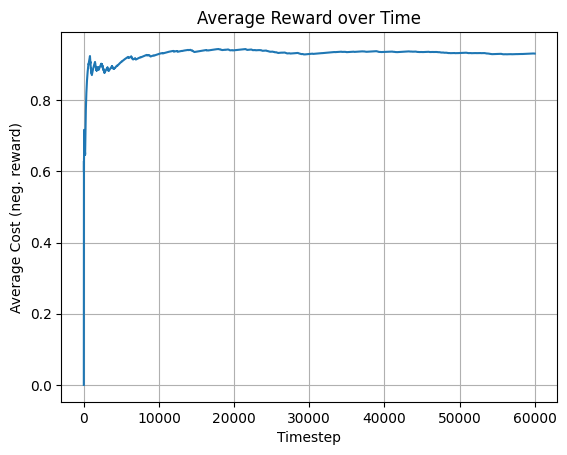

Average num. sensing = 0.9313039224095057


"\nnp.savetxt('Result_AAoI_Gam_1_2000_3000.csv', AAoI_T)\n"

In [96]:
"""
This programm is based on DQN using Convontional [Pill in Github] NN for 2S AoI Minimization
Modified and Customized BY:    Abolfazl Zakeri
"""

import torch
import numpy as np
#from dqn_agent import DQNAgent
import matplotlib.pyplot as plt

#from scipy.signal import pow2db

import time
startTime = time.time()

######################### System Parameter Con.  ##########################
action_mat = [ 0, 1, 2 ]  # idle, sensor 1, sensor 2
q = [ 0.8, 0.6 ]   # channel
rho = [ 0.4 , 0.7 ] 
p = [ 0.9, 0.9 ] # p_1, p_2
alpha_tr = 0.5

d_1 = np.array([[0, 1], [1, 0]])
d_2 = np.array([[0, 1], [1, 0]])
rand_cost = np.zeros((2, 2, 2))  # Shape: (sources, rows, columns)
rand_cost[0, :, :] = d_1
rand_cost[1, :, :] = d_2

#print(rand_cost)
# %% ######################## the Envirenment  ##########################
env = env_goal_crrl( q, rho, p, alpha_tr, rand_cost, action_mat )

if __name__ == '__main__':

    load_checkpoint = True 
    n_epoch = 200; n_iter = 300

    agent = DQNAgent(gamma=0.99999, epsilon=0.99, lr=0.001,
                     input_dims=4, n_actions=3,
                     mem_size=50000, eps_min=0.01,
                     batch_size=64, replace=1000, eps_dec=1e-3,
                     chkpt_dir='./models/', algo='DQNAgent',
                     env_name='env_Sensing')

    if load_checkpoint:
        agent.load_models()
        observation = [0, 0, 1, 1 ]; X_1, X_2 = 0, 0

    indx = 0
    x_ = np.zeros(n_epoch * n_iter)
    x_avr_t = np.zeros(n_epoch * n_iter)
    scores = np.zeros(n_epoch)

    
    for i in range(n_epoch):
        done = False
        if not load_checkpoint: observation = env.reset(); X_1, X_2 = 0, 0
        score = 0
        n_steps = 0
        while not done:
            action = agent.choose_action(observation)
            state = observation
            observation_, reward, nx_X1, nx_X2 = env.step(action, state, X_1, X_2)

            if not load_checkpoint:
                agent.store_transition(observation, action, reward, observation_, done)
                agent.learn()

            observation = observation_; X_1 = nx_X1; X_= nx_X2
            x_[indx] = reward

            if indx > 0:
                x_avr_t[indx] = np.mean(x_[:indx])
            else:
                x_avr_t[indx] = 0

            n_steps += 1
            indx += 1

            if n_steps == n_iter:
                done = True

        scores[i] = np.sum(x_[i * n_iter: (i + 1) * n_iter])

        print(f'Epoch #{i}, Score: {scores[i]:.2f}')


    if not load_checkpoint:
        agent.save_models()

    plt.plot(x_avr_t)
    plt.title("Average Reward over Time")
    plt.xlabel("Timestep")
    plt.ylabel("Average Cost (neg. reward)")
    plt.grid()
    plt.show()

    print('Average num. sensing =', np.mean(x_))

'''
np.savetxt('Result_AAoI_Gam_1_2000_3000.csv', AAoI_T)
'''